In [7]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import scipy.io

%matplotlib inline

In [8]:
#激活函数
def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

def relu(x):
    s = np.maximum(0,x)
    return s

In [9]:
#初始化数据集
def load_dataset():
    np.random.seed(1)
    train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
    np.random.seed(2)
    test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    test_X = test_X.T
    test_Y = test_Y.reshape((1, test_Y.shape[0]))
    return train_X, train_Y, test_X, test_Y

def load_2D_dataset():
    data = scipy.io.loadmat('data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=train_Y, s=40, cmap=plt.cm.Spectral);
    
    return train_X, train_Y, test_X, test_Y

In [34]:
#画出分界
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()
    
def predict_dec(parameters, X):
    
    a3, cache = forward_propagation(X, parameters)
    predictions = (a3>0.5)
    
    return predictions

In [11]:
#前向传播
def forward_propagation(X, parameters):

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    z1 = np.dot(W1, X) + b1
    a1 = relu(z1)
    z2 = np.dot(W2, a1) + b2
    a2 = relu(z2)
    z3 = np.dot(W3, a2) + b3
    a3 = sigmoid(z3)
    
    cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3)
    
    return a3, cache

In [12]:
#反向传播
def backward_propagation(X, Y, cache):
    
    m = X.shape[1]
    (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache
    
    dz3 = 1./m * (a3 - Y)
    dW3 = np.dot(dz3, a2.T)
    db3 = np.sum(dz3, axis=1, keepdims = True)
    
    da2 = np.dot(W3.T, dz3)
    dz2 = np.multiply(da2, np.int64(a2 > 0))
    dW2 = np.dot(dz2, a1.T)
    db2 = np.sum(dz2, axis=1, keepdims = True)
    
    da1 = np.dot(W2.T, dz2)
    dz1 = np.multiply(da1, np.int64(a1 > 0))
    dW1 = np.dot(dz1, X.T)
    db1 = np.sum(dz1, axis=1, keepdims = True)
    
    gradients = {"dz3": dz3, "dW3": dW3, "db3": db3,
                 "da2": da2, "dz2": dz2, "dW2": dW2, "db2": db2,
                 "da1": da1, "dz1": dz1, "dW1": dW1, "db1": db1}
    
    return gradients

In [13]:
#计算成本
def compute_cost(a3, Y):
    
    m = Y.shape[1]
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    loss = 1./m * np.nansum(logprobs)
    
    return loss

In [14]:
#更新参数
def update_parameters(parameters, grads, learning_rate):
    
    n = len(parameters) // 2 
    for k in range(n):
        parameters["W" + str(k+1)] = parameters["W" + str(k+1)] - learning_rate * grads["dW" + str(k+1)]
        parameters["b" + str(k+1)] = parameters["b" + str(k+1)] - learning_rate * grads["db" + str(k+1)]
        
    return parameters

In [32]:
#预测结果
def predict(X, y, parameters):

    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    a3, caches = forward_propagation(X, parameters)

    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    print("识别准确度: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

In [24]:
#建立整个模型
def model(X, Y, learning_rate = 0.01, layers_dims = [], num_iterations = 15000, initialization = "he", lambd = 0, keep_prob = 1,  print_cost = True):
        
    grads = {}
    costs = []                          
    m = X.shape[1]                      
    
    #三种参数初始化
    if initialization == "zeros":
        parameters = initialize_parameters_zeros(layers_dims)
    elif initialization == "random":
        parameters = initialize_parameters_random(layers_dims)
    elif initialization == "he":
        parameters = initialize_parameters_he(layers_dims)
  
    for i in range(0, num_iterations):

        # 前向传播: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # 损失函数
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd) #L2正则化
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob) #DropOut正则化
        
        #更新参数 
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 3000 == 0:
            print("循环{}次后的成本值: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    #画出成本曲线
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [25]:
#参数w,b初始化为0
def initialize_parameters_zeros(layers_dims):
    
    parameters = {}
    L = len(layers_dims)           
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.zeros((layers_dims[l],layers_dims[l-1]))
        parameters['b' + str(l)] = np.zeros((layers_dims[l],1))
    return parameters

#参数w初始化为random
def initialize_parameters_random(layers_dims):
    
    np.random.seed(3)              
    parameters = {}
    L = len(layers_dims)           
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1]) * 10
        parameters['b' + str(l)] = np.zeros((layers_dims[l],1))
    return parameters
 
#参数w进行Xavier初始化
def initialize_parameters_he(layers_dims):
    
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1
     
    for l in range(1, L + 1):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1]) * np.sqrt(1.0/(layers_dims[l-1]))
        parameters['b' + str(l)] = np.zeros((layers_dims[l],1))
    return parameters


In [26]:
#L2正则化下损失计算
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y)
    L2_regularization_cost = lambd*(np.sum(np.square(W1))+np.sum(np.square(W2))+np.sum(np.square(W3)))/(2*m) #L2正则化项
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [27]:
#L2正则化下反向传播
def backward_propagation_with_regularization(X, Y, cache, lambd):
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    
    dW3 = 1./m * np.dot(dZ3, A2.T) + lambd*W3/m
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T) + lambd*W2/m
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T) + lambd*W1/m
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [28]:
#DropOut正则化下前向传播
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):

    np.random.seed(1)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    D1 = np.random.rand(A1.shape[0],A1.shape[1])                                         
    D1 = D1 < keep_prob                                         
    A1 = np.multiply(A1,D1)                                        
    A1 = A1 / keep_prob                                        
   
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    D2 = np.random.rand(A2.shape[0],A2.shape[1])                                        
    D2 = D2 < keep_prob                                         
    A2 = np.multiply(A2,D2)                                         
    A2 = A2 / keep_prob                                         

    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [29]:
#DropOut正则化下反向传播
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dA2 = np.multiply(dA2,D2)              
    dA2 = dA2 / keep_prob              
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dA1 = np.multiply(dA1,D1)              
    dA1 = dA1 / keep_prob              
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [41]:
#梯度检验转换
def dictionary_to_vector(parameters):
    keys = []
    count = 0
    for key in ["W1", "b1", "W2", "b2", "W3", "b3"]:
        
        # flatten parameter
        new_vector = np.reshape(parameters[key], (-1,1))
        keys = keys + [key]*new_vector.shape[0]
        
        if count == 0:
            theta = new_vector
        else:
            theta = np.concatenate((theta, new_vector), axis=0)
        count = count + 1

    return theta, keys

def vector_to_dictionary(theta):

    parameters = {}
    parameters["W1"] = theta[:20].reshape((5,4))
    parameters["b1"] = theta[20:25].reshape((5,1))
    parameters["W2"] = theta[25:40].reshape((3,5))
    parameters["b2"] = theta[40:43].reshape((3,1))
    parameters["W3"] = theta[43:46].reshape((1,3))
    parameters["b3"] = theta[46:47].reshape((1,1))

    return parameters

def gradients_to_vector(gradients):

    count = 0
    for key in ["dW1", "db1", "dW2", "db2", "dW3", "db3"]:
        # flatten parameter
        new_vector = np.reshape(gradients[key], (-1,1))
        
        if count == 0:
            theta = new_vector
        else:
            theta = np.concatenate((theta, new_vector), axis=0)
        count = count + 1

    return theta

In [42]:
#梯度检验中的前向传播
def forward_propagation_n(X, Y, parameters):

    m = X.shape[1]
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]

    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)

    # Cost
    logprobs = np.multiply(-np.log(A3),Y) + np.multiply(-np.log(1 - A3), 1 - Y)
    cost = 1./m * np.sum(logprobs)
    
    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)
    
    return cost, cache

In [43]:
#梯度检验中的反向传播
def backward_propagation_n(X, Y, cache):
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T) * 2
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 4./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

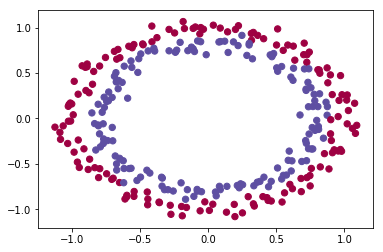

In [30]:
#三种Initialization比较
train_X, train_Y, test_X, test_Y = load_dataset()

循环0次后的成本值: 0.6931471805599453
循环3000次后的成本值: 0.6931471805599453
循环6000次后的成本值: 0.6931471805599453
循环9000次后的成本值: 0.6931471805599453
循环12000次后的成本值: 0.6931471805599453


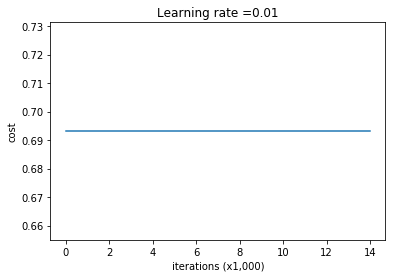

/home/binweber/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/home/binweber/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


循环0次后的成本值: inf
循环3000次后的成本值: 0.5637539062842213
循环6000次后的成本值: 0.5373895855049121
循环9000次后的成本值: 0.3934560146692851
循环12000次后的成本值: 0.3861358766546214


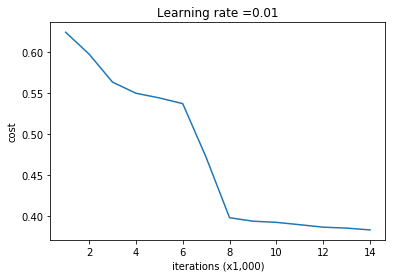

循环0次后的成本值: 0.729451703805014
循环3000次后的成本值: 0.6783983102177117
循环6000次后的成本值: 0.5845947883351541
循环9000次后的成本值: 0.2944433152121501
循环12000次后的成本值: 0.150080097183777


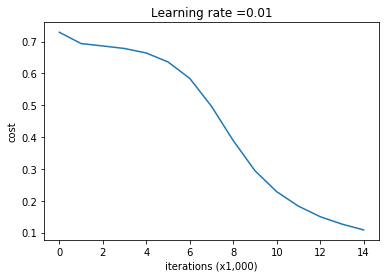

In [31]:
layers = [train_X.shape[0], 10, 5, 1] #设置神经网络层数及节点数

#参数初始化为0
parameters_init_zeros = model(train_X, train_Y, layers_dims = layers, initialization = "zeros")

#初始化random
parameters_init_random = model(train_X, train_Y, layers_dims = layers, initialization = "random")

#Xavier初始化
parameters_init_he = model(train_X, train_Y, layers_dims = layers, initialization = "he")

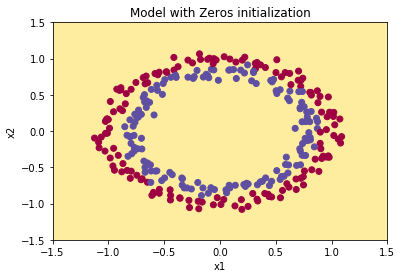

训练集中:
识别准确度: 0.5
测试集中:
识别准确度: 0.5


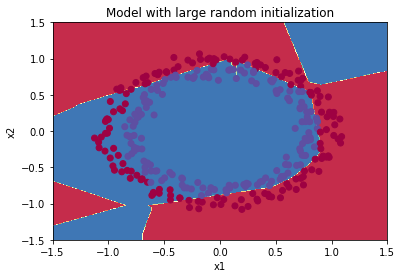

训练集中:
识别准确度: 0.83
测试集中:
识别准确度: 0.86


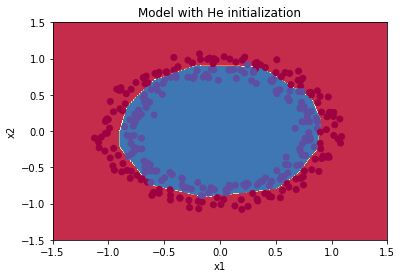

训练集中:
识别准确度: 0.99
测试集中:
识别准确度: 0.93


In [35]:
#参数初始化为0时
plt.title("Model with Zeros initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters_init_zeros, x.T), train_X, train_Y)
print ("训练集中:")
predictions_train = predict(train_X, train_Y, parameters_init_zeros)
print ("测试集中:")
predictions_test = predict(test_X, test_Y, parameters_init_zeros)

#参数初始化为random时
plt.title("Model with large random initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters_init_random, x.T), train_X, train_Y)
print ("训练集中:")
predictions_train = predict(train_X, train_Y, parameters_init_random)
print ("测试集中:")
predictions_test = predict(test_X, test_Y, parameters_init_random)

#Xavier初始化
plt.title("Model with He initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters_init_he, x.T), train_X, train_Y)
print ("训练集中:")
predictions_train = predict(train_X, train_Y, parameters_init_he)
print ("测试集中:")
predictions_test = predict(test_X, test_Y, parameters_init_he)

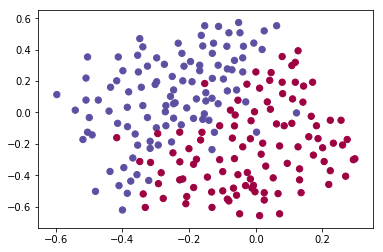

In [36]:
#几种Regularization比较
train_x, train_y, test_x, test_y = load_2D_dataset()

循环0次后的成本值: 0.6557412523481002
循环3000次后的成本值: 0.1825149792468696
循环6000次后的成本值: 0.16832730392115422
循环9000次后的成本值: 0.1594261225324511
循环12000次后的成本值: 0.15764474148193
循环15000次后的成本值: 0.14796400922574224
循环18000次后的成本值: 0.14335088537382062
循环21000次后的成本值: 0.14118678351815028
循环24000次后的成本值: 0.13032326002023897
循环27000次后的成本值: 0.1326384651881861


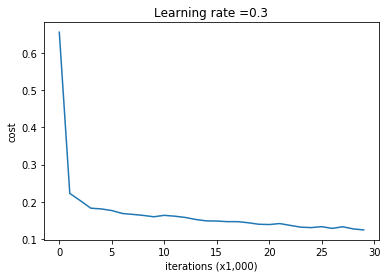

循环0次后的成本值: 0.6974484493131264
循环3000次后的成本值: 0.269508280641266
循环6000次后的成本值: 0.2688974560734563
循环9000次后的成本值: 0.2685595174585009
循环12000次后的成本值: 0.268370115369031
循环15000次后的成本值: 0.26821990337290474
循环18000次后的成本值: 0.26813316999149156
循环21000次后的成本值: 0.2680382189950236
循环24000次后的成本值: 0.2678953595054706
循环27000次后的成本值: 0.2679162550106563


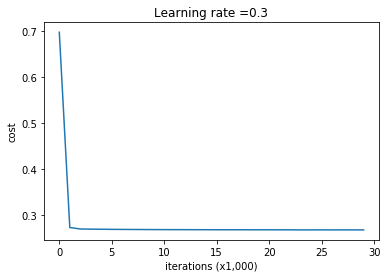

循环0次后的成本值: 0.6543912405149825
循环3000次后的成本值: 0.07661297787357767


/home/binweber/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/home/binweber/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


循环6000次后的成本值: 0.06240987259698129
循环9000次后的成本值: 0.06119214375763485
循环12000次后的成本值: 0.06082640196596114
循环15000次后的成本值: 0.06066457216128777
循环18000次后的成本值: 0.06065874505596672
循环21000次后的成本值: 0.060559199380913156
循环24000次后的成本值: 0.060503590269931996
循环27000次后的成本值: 0.060473147392254074


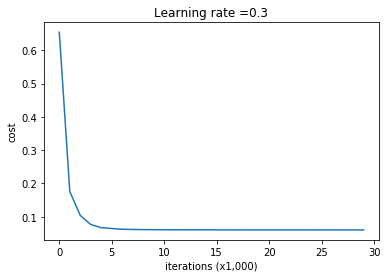

In [37]:
layers = [train_x.shape[0], 20, 3, 1] #设置神经网络层数及节点数

#不进行正则化
parameters_no_reg = model(train_x, train_y, layers_dims = layers, learning_rate = 0.3, num_iterations = 30000)

#采用L2正则化
parameters_L2_reg = model(train_x, train_y, layers_dims = layers, learning_rate = 0.3, num_iterations = 30000, lambd = 0.7)

#采用DropOut正则化
parameters_dropout_reg = model(train_x, train_y, layers_dims = layers, learning_rate = 0.3, num_iterations = 30000, keep_prob = 0.86)

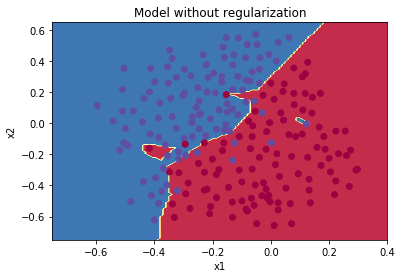

训练集中:
识别准确度: 0.947867298578
测试集中:
识别准确度: 0.915


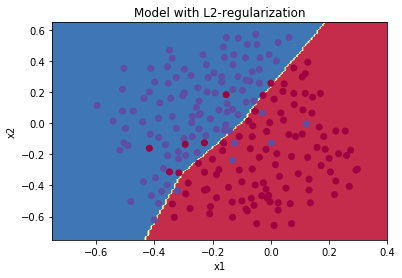

训练集中:
识别准确度: 0.938388625592
测试集中:
识别准确度: 0.93


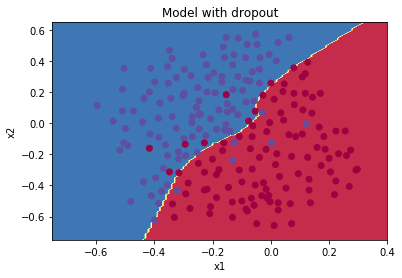

训练集中:
识别准确度: 0.928909952607
测试集中:
识别准确度: 0.95


In [39]:
#不进行正则化
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters_no_reg, x.T), train_x, train_y)
print ("训练集中:")
predictions_train = predict(train_x, train_y, parameters_no_reg)
print ("测试集中:")
predictions_test = predict(test_x, test_y, parameters_no_reg)

#进行L2正则化
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters_L2_reg, x.T), train_x, train_y)
print ("训练集中:")
predictions_train = predict(train_x, train_y, parameters_L2_reg)
print ("测试集中:")
predictions_test = predict(test_x, test_y, parameters_L2_reg)

#DropOut正则化
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters_dropout_reg, x.T), train_x, train_y)
print ("训练集中:")
predictions_train = predict(train_x, train_y, parameters_dropout_reg)
print ("测试集中:")
predictions_test = predict(test_x, test_y, parameters_dropout_reg)

In [44]:
#梯度检验
def gradient_check_n(parameters, gradients, X, Y, epsilon = 1e-7):

    parameters_values, _ = dictionary_to_vector(parameters)
    grad = gradients_to_vector(gradients)
    num_parameters = parameters_values.shape[0]
    J_plus = np.zeros((num_parameters, 1))
    J_minus = np.zeros((num_parameters, 1))
    gradapprox = np.zeros((num_parameters, 1))
    
    for i in range(num_parameters):
        
        thetaplus = np.copy(parameters_values)                                      
        thetaplus[i][0] = thetaplus[i][0] + epsilon                                 
        J_plus[i], _ =  forward_propagation_n(X, Y, vector_to_dictionary(thetaplus))                                                                     
    
        thetaminus = np.copy(parameters_values)                                   
        thetaminus[i][0] = thetaminus[i][0] - epsilon                                     
        J_minus[i], _ = forward_propagation_n(X, Y, vector_to_dictionary(thetaminus))                               
        gradapprox[i] = (J_plus[i] - J_minus[i])/(2*epsilon) 
 
    numerator = np.linalg.norm(grad - gradapprox)                            
    denominator = np.linalg.norm(grad) + np.linalg.norm(gradapprox)                             
    difference = numerator/denominator                                          

    if difference > 1e-7:
        print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
    else:
        print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")
    
    return difference